# Task 1: Time-series Analysis

The problem I'm solving using time-series analysis is gas price predictions in UK using weekly gas price in UK data ([Source](https://data.world/makeovermonday/2020w17-weekly-road-fuel-prices)). \\
This problem is best solved using sequence modeling because there are usually not a lot of representable features that impact gas price, and its price tends to change constantly over time, making it easier to predict over time than other classes. \\
Specifically for this data, the only column besides the petrol and diesel prices is time, so any model using this data must rely only on values at previous timesteps to make future predictions.

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

import tensorflow as tf

## Load Data

In [12]:
data = pd.read_excel('/content/Weekly Fuel Prices.xlsx')
data.head()

,Date,Petrol (USD),Diesel (USD)
0,2003-06-09 00:00:00,74.590284,76.773394
1,2003-06-16 00:00:00,74.469143,76.689054
2,2003-06-23 00:00:00,74.423566,76.620546
3,2003-06-30 00:00:00,74.352421,76.505260
4,2003-07-07 00:00:00,74.283737,76.457376


In [21]:
petrol_col = 'Petrol (USD)'
diesel_col = 'Diesel (USD)'

## EDA

In [13]:
data.describe()

,Petrol (USD),Diesel (USD)
count,881.000000,881.000000
mean,111.107355,115.614675
std,18.588151,19.715905
min,74.206577,76.408120
25%,95.306029,98.513787
50%,114.782386,118.597998
75%,127.924651,132.872053
max,142.172754,148.037710


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          882 non-null    object 
 1   Petrol (USD)  881 non-null    float64
 2   Diesel (USD)  881 non-null    float64
dtypes: float64(2), object(1)
memory usage: 20.8+ KB


In [17]:
data

,Date,Petrol (USD),Diesel (USD)
0,2003-06-09 00:00:00,74.590284,76.773394
1,2003-06-16 00:00:00,74.469143,76.689054
2,2003-06-23 00:00:00,74.423566,76.620546
3,2003-06-30 00:00:00,74.352421,76.505260
4,2003-07-07 00:00:00,74.283737,76.457376
...,...,...,...
878,2020-04-06 00:00:00,110.234797,116.833354
879,2020-04-13 00:00:00,109.265819,116.150812
880,2020-04-20 00:00:00,108.632747,115.732573
881,NaN,NaN,NaN


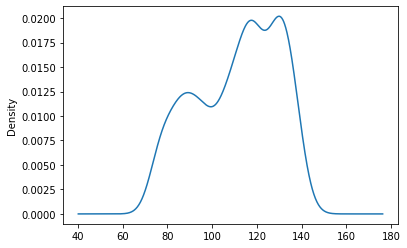

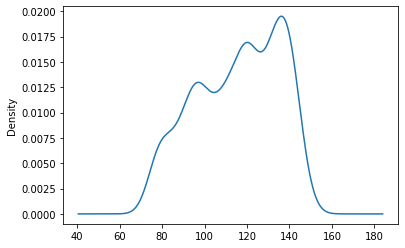

In [75]:
# Distribution graphs (complex distributions)
plt.figure()
data[petrol_col].plot(kind='kde')

plt.figure()
data[diesel_col].plot(kind='kde')

## Data Pre-processing

In [79]:
# Contains two null rows, remove the rows

new_data = data.dropna()
date_time = pd.to_datetime(new_data['Date'], format='%d.%m.%Y %H:%M:%S')
new_data['Date'] = date_time.map(pd.Timestamp.timestamp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [80]:
# Normalize data
final_data = (new_data - new_data.min()) / (new_data.max() - new_data.min())
final_data.head()

,Date,Petrol (USD),Diesel (USD)
0,0.000000,0.005646,0.005099
1,0.001136,0.003863,0.003922
2,0.002273,0.003193,0.002966
3,0.003409,0.002146,0.001356
4,0.004545,0.001135,0.000688


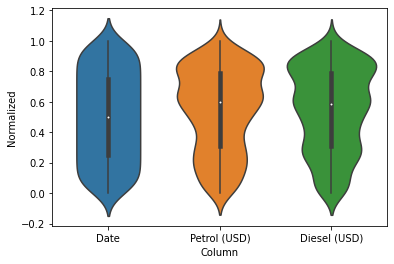

In [81]:
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=final_data.melt(var_name='Column', value_name='Normalized'))
_ = ax.set_xticklabels(final_data.keys())

### Train-test-val Split

In [149]:
n = len(final_data)
train_data = final_data[0:int(n*0.7)]
val_data = final_data[int(n*0.7):int(n*0.9)]
test_data = final_data[int(n*0.9):]

len(train_data), len(test_data), len(val_data)

(616, 89, 176)

### Window Generator
Borrowed from [time forecasting tutorial notebook](https://www.tensorflow.org/tutorials/structured_data/time_series) in Tensorflow documentation

In [224]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_data, val_df=val_data, test_df=test_data, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col=diesel_col, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [225]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[petrol_col, diesel_col])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Petrol (USD)', 'Diesel (USD)']

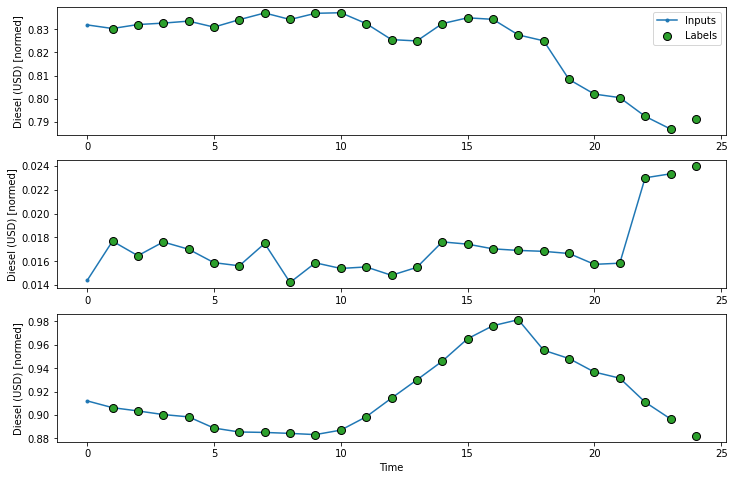

In [226]:
wide_window.plot()

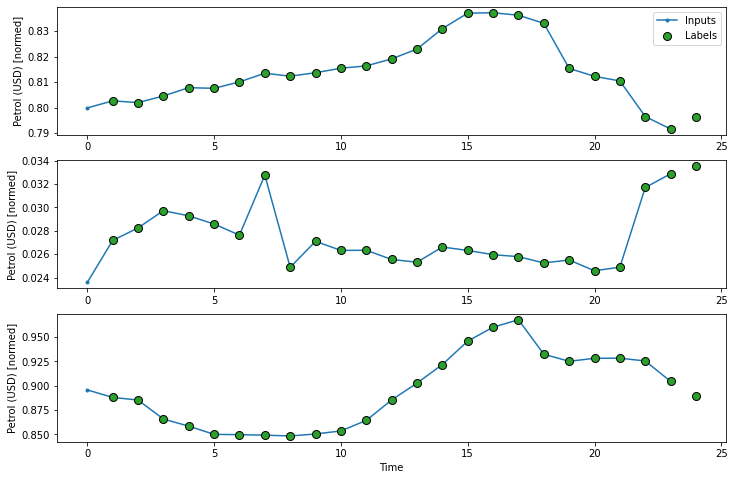

In [227]:
wide_window.plot(plot_col=petrol_col)

## Part 1: Implement RNN

This implementation of a Recurrent Neural Network (RNN) is done using Tensorflow's built-in Sequential model structure. The overall model contains a simple RNN of 10 units, followed by an fully connected output layer of size 2, since the final output should contain predictions for the petrol price and diesel price. The activation function used for the timesteps in the RNN is the tanh function and the output layer activation function is ReLU to ensure that only positive values are being predicted. \\
Within the RNN, the initial input is the data, and the initial output is a prediction by using a connected layer. In following units though, the input becomes a value representing memory from the previous unit along with the current input sample. Over time, the learned weights are the weights relating an input along with the previous memory to a prediction. \\
The metric used to measure the performance of the model is the same as a typical linear regression problem: Mean Absolute Error. This can be used for this problem because gas price is a simple continuous value, so determining the strength of a prediction of it is the same as for any continuous value.

In [247]:
rnn_model = tf.keras.models.Sequential()
rnn_model.add(tf.keras.layers.SimpleRNN(10, return_sequences=True))
rnn_model.add(tf.keras.layers.Dense(2, activation='relu'))

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = rnn_model.fit(wide_window.train, epochs=100, validation_data=wide_window.val)

val_performance = rnn_model.evaluate(wide_window.val, verbose=0)
performance = rnn_model.evaluate(wide_window.test, verbose=0)

Epoch 1/100
19/19 [==============================] - 2s 24ms/step - loss: 0.3284 - mean_absolute_error: 0.4872 - val_loss: 0.2776 - val_mean_absolute_error: 0.5086
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.2139 - mean_absolute_error: 0.3572 - val_loss: 0.1835 - val_mean_absolute_error: 0.3485
Epoch 3/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1779 - mean_absolute_error: 0.2924 - val_loss: 0.1788 - val_mean_absolute_error: 0.3344
Epoch 4/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1232 - mean_absolute_error: 0.2330 - val_loss: 0.0607 - val_mean_absolute_error: 0.1845
Epoch 5/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0478 - mean_absolute_error: 0.1619 - val_loss: 0.0171 - val_mean_absolute_error: 0.0834
Epoch 6/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1234 - val_loss: 0.0162 - val_mean_absolute_error: 0.0808
Epoch 7/100
19/1

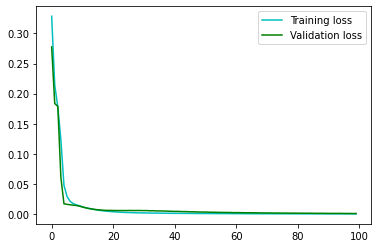

In [251]:
# Loss plot
plt.figure(1)
plt.plot(range(100), history.history['loss'], label='Training loss', color='c')
plt.plot(range(100), history.history['val_loss'], label='Validation loss', color='g')
plt.legend()

plt.show()

In [252]:
val_performance, performance

([0.001044894685037434, 0.02502216026186943],
 [0.0010751000372692943, 0.02884691394865513])

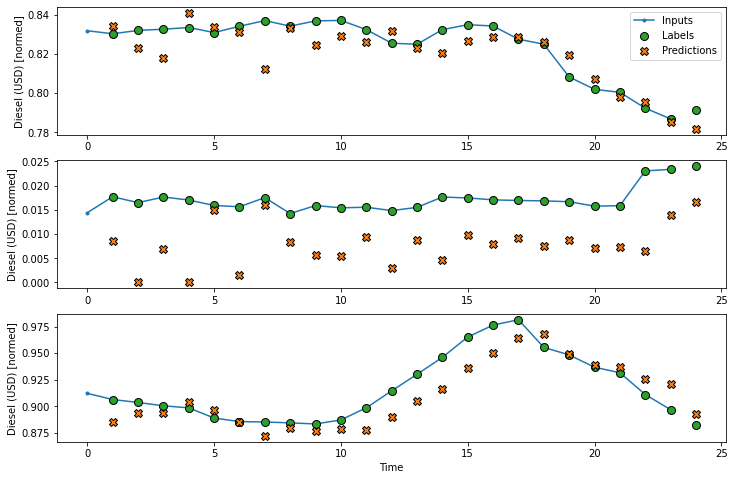

In [253]:
wide_window.plot(model=rnn_model)

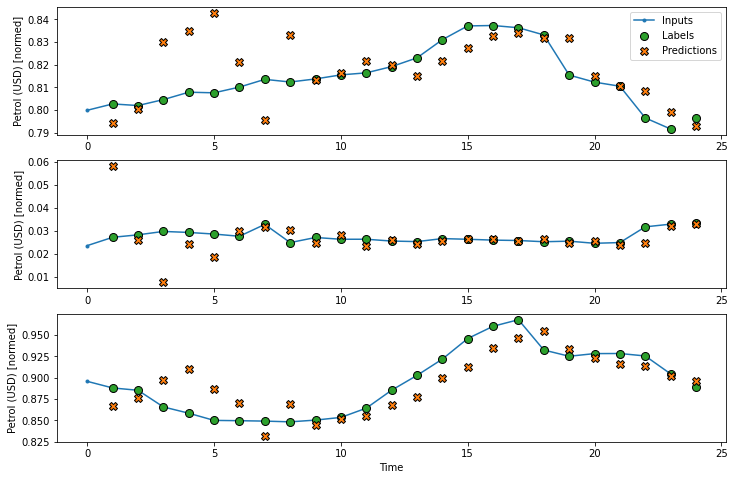

In [254]:
wide_window.plot(model=rnn_model, plot_col=petrol_col)

## Part 2: Implement LSTM and GRU

### LSTM:

In [255]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(10, return_sequences=True))
lstm_model.add(tf.keras.layers.Dense(2, activation='relu'))

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = lstm_model.fit(wide_window.train, epochs=100, validation_data=wide_window.val)

val_performance = lstm_model.evaluate(wide_window.val, verbose=0)
performance = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/100
19/19 [==============================] - 4s 46ms/step - loss: 0.3246 - mean_absolute_error: 0.4767 - val_loss: 0.1093 - val_mean_absolute_error: 0.2819
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1683 - mean_absolute_error: 0.3189 - val_loss: 0.0821 - val_mean_absolute_error: 0.2392
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0852 - mean_absolute_error: 0.2303 - val_loss: 0.0683 - val_mean_absolute_error: 0.2147
Epoch 4/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0551 - mean_absolute_error: 0.1795 - val_loss: 0.0434 - val_mean_absolute_error: 0.1824
Epoch 5/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0417 - mean_absolute_error: 0.1462 - val_loss: 0.0377 - val_mean_absolute_error: 0.1743
Epoch 6/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0347 - mean_absolute_error: 0.1268 - val_loss: 0.0290 - val_mean_absolute_error: 0.1514
Epoch 7/100
19/1

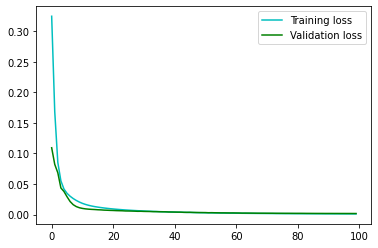

In [256]:
# Loss plot
plt.figure(1)
plt.plot(range(100), history.history['loss'], label='Training loss', color='c')
plt.plot(range(100), history.history['val_loss'], label='Validation loss', color='g')
plt.legend()

plt.show()

In [257]:
val_performance, performance

([0.0016249284381046891, 0.027170443907380104],
 [0.0019232371123507619, 0.03461537882685661])

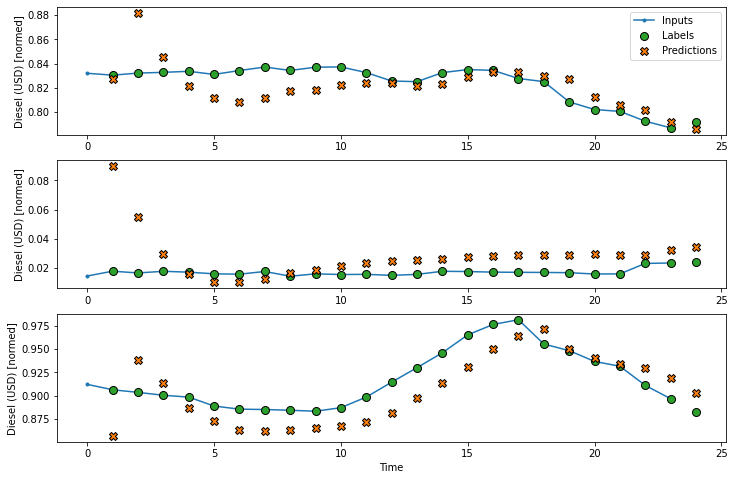

In [258]:
wide_window.plot(model=lstm_model)

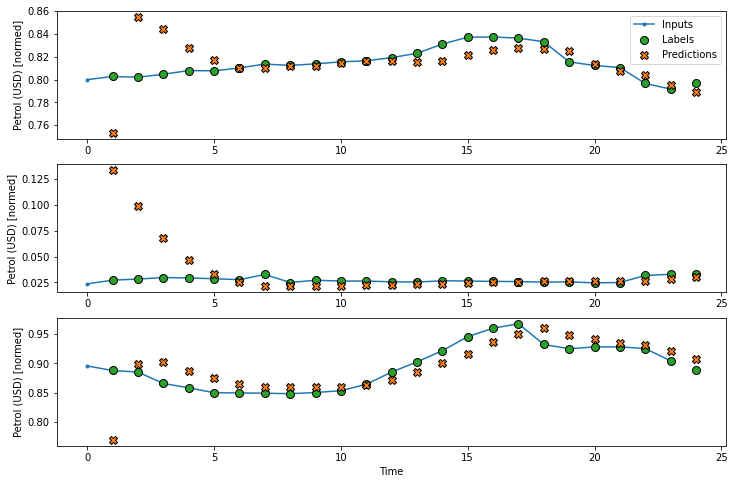

In [259]:
wide_window.plot(model=lstm_model, plot_col=petrol_col)

### GRU:

In [260]:
gru_model = tf.keras.models.Sequential()
gru_model.add(tf.keras.layers.GRU(10, return_sequences=True))
gru_model.add(tf.keras.layers.Dense(2, activation='relu'))

gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = gru_model.fit(wide_window.train, epochs=100, validation_data=wide_window.val)

val_performance = gru_model.evaluate(wide_window.val, verbose=0)
performance = gru_model.evaluate(wide_window.test, verbose=0)

Epoch 1/100
19/19 [==============================] - 3s 45ms/step - loss: 0.2745 - mean_absolute_error: 0.4288 - val_loss: 0.1655 - val_mean_absolute_error: 0.3192
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 0.2013 - mean_absolute_error: 0.3387 - val_loss: 0.1975 - val_mean_absolute_error: 0.4128
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 0.1447 - mean_absolute_error: 0.2766 - val_loss: 0.0853 - val_mean_absolute_error: 0.2567
Epoch 4/100
19/19 [==============================] - 1s 32ms/step - loss: 0.0453 - mean_absolute_error: 0.1752 - val_loss: 0.0606 - val_mean_absolute_error: 0.2253
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0256 - mean_absolute_error: 0.1307 - val_loss: 0.0351 - val_mean_absolute_error: 0.1752
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0197 - mean_absolute_error: 0.1112 - val_loss: 0.0358 - val_mean_absolute_error: 0.1770
Epoch 7/100
19/1

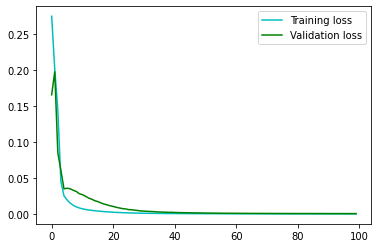

In [261]:
# Loss plot
plt.figure(1)
plt.plot(range(100), history.history['loss'], label='Training loss', color='c')
plt.plot(range(100), history.history['val_loss'], label='Validation loss', color='g')
plt.legend()

plt.show()

In [262]:
val_performance, performance

([0.0007082130759954453, 0.018079495057463646],
 [0.0013300048885867, 0.028642920777201653])

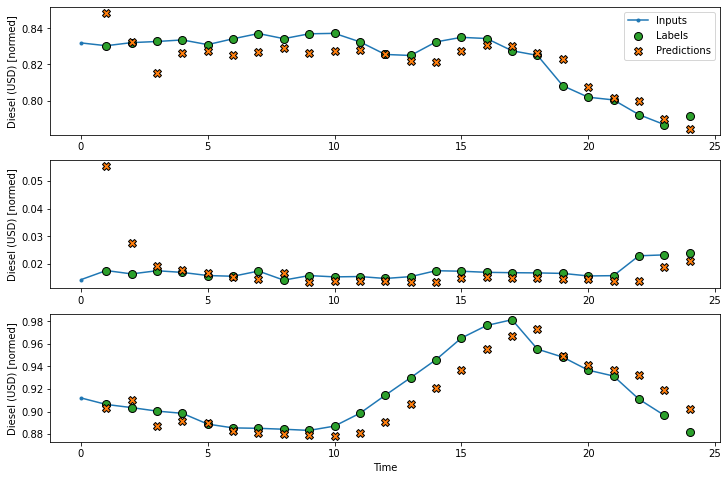

In [263]:
wide_window.plot(model=gru_model)

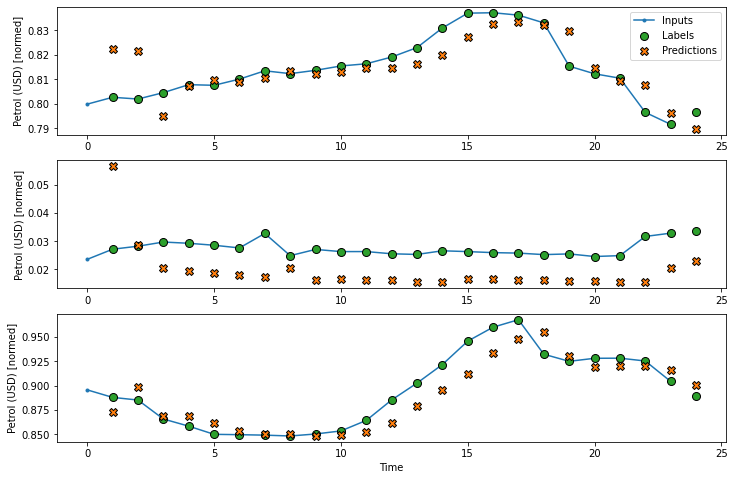

In [264]:
wide_window.plot(model=gru_model, plot_col=petrol_col)

Discussion: \\
The GRU model performs best, then LSTM, then a baseline RNN. The initial predictions of all 3 models are pretty far off from the true values, as expected, but the amount of time it takes for the models to adjust to the true time trend is what differentiates them. The GRU model adjusts fairly quickly and thus has close predictions for most of the timesteps. The next best model, LSTM, is off for about 5 extra steps from the true values compared to GRU. Lastly, the RNN model takes about half the time interval (total 24 steps) to adjust to the true trend, so only half of its predictions are close to the true values, which is why its final error is higher than the other two models. \\
The difference in performances is likely due to the difference in architecture between the 3 variations. Each of the models varies in the number of gates and weights it uses to pass information between units. The RNN simply passes memory through a single gate. The GRU architecture captures information between previous and following memory through multiple gates, which provides the chance to learn more relations between samples. An LSTM uses one more gate than GRU. Even though, in this problem, GRU performs better than LSTM, both performing better than the RNN can be explained by this architecture difference. Between GRU and LSTM, a likely reason could be that using extra gates could overcomplicate the relationships between samples than needed for this problem.

## Part 3
It would be difficult for a traditional network to solve a problem like this, especially because of the lack of features describing the class and the dependency of different samples on each other. The main difference between a traditional network and a recurrent network is the extra input in training that corresponds to memory. This input allows a recurrent model to directly use previous samples to help predict the current sample's value. In traditional networks, although the weights utilize all samples and therefore can capture some relations between samples, they can't describe data that is as connected between samples as time-series data.

# Task 2

In [269]:
embeddings = pd.read_csv('vectors.tsv', sep='\t', header=None)

In [270]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.169345,-0.179036,-0.090216,-0.062181,0.169573,0.258825,-0.299072,0.045441,-0.242324,0.504593,...,0.090447,0.099050,-0.125761,-0.030978,-0.032489,-0.164193,-0.018079,-0.073613,0.366503,-0.018523
1,-0.303247,0.209272,-0.093077,-0.193185,-0.176455,0.319230,-0.024672,-0.104974,-0.191501,-0.184814,...,-0.256361,-0.094947,0.217065,-0.038342,-0.352264,0.076255,-0.226904,0.170016,0.009632,-0.046813
2,-0.263350,-0.021495,0.110468,-0.045513,0.182673,0.162113,-0.350620,0.032931,-0.080561,-0.110979,...,-0.221913,-0.147411,-0.319237,0.188823,0.032133,-0.257982,0.035306,0.012090,0.248531,-0.236379
3,0.219948,-0.176056,-0.293224,-0.172641,0.219710,0.166159,0.316989,0.209058,-0.255508,-0.244863,...,0.530954,-0.273119,0.455745,-0.094651,-0.162632,0.155243,0.087540,0.103126,0.027902,-0.052115
4,-0.207951,-0.312110,0.342040,-0.145165,-0.403153,-0.050596,-0.025975,0.049603,-0.208119,-0.074978,...,-0.045956,0.385242,0.377382,0.192257,-0.221616,-0.096130,-0.036569,-0.192661,0.140990,0.170524


In [286]:
# Cosine similarity: dot(A, B) / (||A|| * ||B||)
def cos_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Dissimilarity: ||A - B||
def dissimilarity(a, b):
    return np.linalg.norm(a - b)


In [282]:
# Test for cosine similarity between pairs of words

np_embeddings = embeddings.to_numpy()
similarities = []
for i in range(50):
    for j in range(i, 50):
        if i == j: continue
        similarities.append(cos_similarity(np_embeddings[i], np_embeddings[j]))
        print("Cosine similarity between word " + str(i) + " and word " + str(j) + ":", similarities[-1])

Cosine similarity between word 0 and word 1: 0.11379908384985132
Cosine similarity between word 0 and word 2: 0.20531611181403106
Cosine similarity between word 0 and word 3: 0.13748127079203393
Cosine similarity between word 0 and word 4: 0.27222291682492655
Cosine similarity between word 0 and word 5: 0.045204209571107844
Cosine similarity between word 0 and word 6: 0.10639306256511365
Cosine similarity between word 0 and word 7: 0.1502635499677977
Cosine similarity between word 0 and word 8: 0.2497208341513813
Cosine similarity between word 0 and word 9: 0.3229302151718837
Cosine similarity between word 0 and word 10: 0.11467232507032525
Cosine similarity between word 0 and word 11: 0.20011087917283069
Cosine similarity between word 0 and word 12: 0.31930634717021067
Cosine similarity between word 0 and word 13: 0.05612450919749889
Cosine similarity between word 0 and word 14: 0.1689715956031778
Cosine similarity between word 0 and word 15: 0.18179849908469997
Cosine similarity betw

In [283]:
# Test for dissimilarity between pairs of words

np_embeddings = embeddings.to_numpy()
dissimilarities = []
for i in range(50):
    for j in range(i, 50):
        if i == j: continue
        dissimilarities.append(dissimilarity(np_embeddings[i], np_embeddings[j]))
        print("Dissimilarity between word " + str(i) + " and word " + str(j) + ":", dissimilarities[-1])

Dissimilarity between word 0 and word 1: 3.0434578367833494
Dissimilarity between word 0 and word 2: 2.838662723675473
Dissimilarity between word 0 and word 3: 3.080525556070907
Dissimilarity between word 0 and word 4: 3.0128611431589234
Dissimilarity between word 0 and word 5: 3.4257580598570856
Dissimilarity between word 0 and word 6: 3.265011382703761
Dissimilarity between word 0 and word 7: 3.3193326743412834
Dissimilarity between word 0 and word 8: 2.8490551289780983
Dissimilarity between word 0 and word 9: 2.5103159118824796
Dissimilarity between word 0 and word 10: 2.9827762739236547
Dissimilarity between word 0 and word 11: 2.6986322404044087
Dissimilarity between word 0 and word 12: 2.6238824018400995
Dissimilarity between word 0 and word 13: 3.0571718977537925
Dissimilarity between word 0 and word 14: 3.04594987643647
Dissimilarity between word 0 and word 15: 2.8607274789416386
Dissimilarity between word 0 and word 16: 2.994656691280071
Dissimilarity between word 0 and word 1

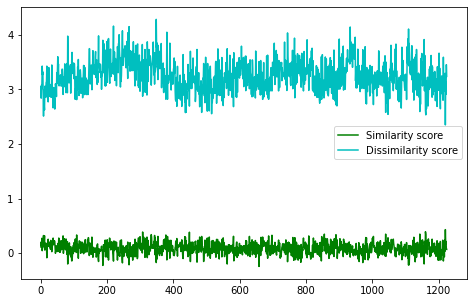

In [285]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(similarities)), similarities, label='Similarity score', color='g')
plt.plot(range(len(dissimilarities)), dissimilarities, label='Dissimilarity score', color='c')
plt.legend()

plt.show()

The dissimilarity score I chose was simply the distance between two vectors, determined by the magnitude of the difference between the vectors. This works as a metric for dissimilarity because it increases as two words have individual embeddings that are further apart. The downside, though, is that a single feature that is very different in value between two words would have a similar score to two words that are only slightly different in many features. Besides this, for the sample tested, the dissimilarity score is inversely proportionate to the cosine similarity score, so it provides a good enough metric for the data being used in this project.